# Cell Typist
 A tool for automated cell type annotation of scRNA-seq data.
 They have models trained on curated datasets which can be used to assign cell type labels on any dataset.
 The code is incredibly short and powerful if you have matching data.
 Of course, watch out for subtle differences between your data and the model, and consider deeper validation before relying on these results.

In [ ]:
import celltypist
from celltypist import models

import sys
from pathlib import Path
# Add the preprocessing folder to the Python path
script_dir = Path('../../preprocessing')
sys.path.append(str(script_dir))
from load_and_prepare_data import adult_human_heart

# let's load our AnnotatedData object
adata = adult_human_heart(
    expression_matrix=Path("../../data/GSE109816_normal_heart_umi_matrix.csv.gz"),
    metadata_path=Path("../../data/GSE109816_normal_heart_cell_cluster_info.txt")
)

## Since we're using adult human heart data, we can use the model trained on healthy adult heart data
model = models.Model.load(model='Healthy_Adult_Heart.pkl')
## you can use this line to see all available models:
# models.models_description()

In [2]:
# This is the main function that annotates our cells based on the model chosen
result = celltypist.annotate(adata, model=model, majority_voting=True)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 6731 cells and 5000 genes
🔗 Matching reference genes in the model
🧬 890 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [3]:
## Now we can align the predictions with the original data
pred_labels = result.predicted_labels

# Remove duplicates
pred_labels = pred_labels[~pred_labels.index.duplicated(keep='first')]
adata = adata[~adata.obs_names.duplicated(keep='first')]
# Also restrict to shared indices
shared_cells = adata.obs_names.intersection(pred_labels.index)

# Get the most probable label per cell
cell_types = pred_labels.loc[shared_cells, "predicted_labels"]
majority_voting = pred_labels.loc[shared_cells, "majority_voting"]
over_clustering = pred_labels.loc[shared_cells, "over_clustering"]

# Add data to the object
adata.obs['cell_type'] = cell_types
adata.obs['cell_type_majority'] = majority_voting
adata.obs['over_clustering'] = over_clustering

... storing 'Condition' as categorical
... storing 'Group' as categorical
... storing 'Cluster_ID' as categorical
... storing 'CellType' as categorical


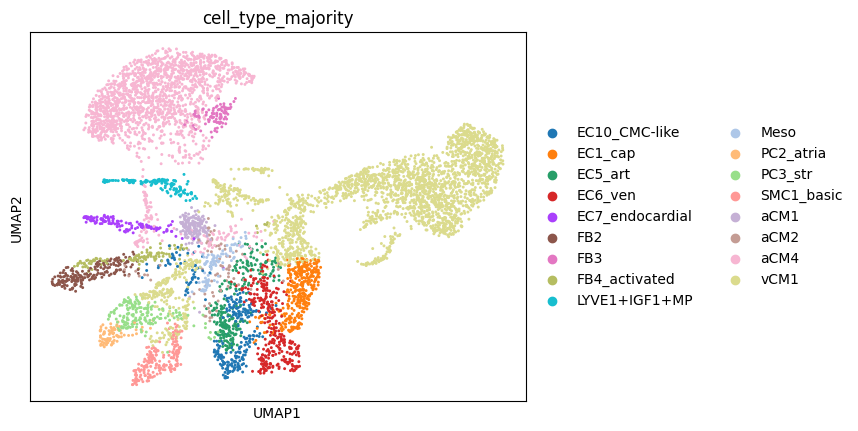

In [5]:
## Plot the predictions
import scanpy as sc
sc.pl.umap(adata, color='cell_type_majority', legend_loc='right margin')